# Data Exploration

## What is the key defining attribute of a successful movie?

The goal of this project is to identify the cause and effect of the many variables which influence both the ratings and gross return of a movie. The data used is self-sourced primarily for the reason that existing data does not contain many of the features which I would like to explore and analyse. 

The project will focus on both statistical analysis of the numerical data and natural language processing techniques which will be used in machine learning algorithms for the prediction of a films success based on a number of features.

This topic interest me due to the potential scope and complexity of the data. There are many factores which may increase a movies success from its budget, its actors and potentially its storyline, all of which could be used in predicting the success of future movies based upon this analysis.

### Web Scraping using Scrapy Crawl


While there are plenty of movies datasets which may be found online none of which I found contained the data size or depth to satisfy my ambitions for this project. As a result I have scrapped the www.imdb.com website using my own web crawler which I have attempted to make as polite as possible to the website servers by obeying the robots.txt file, enabling auto throttling and enabling cache saving.

The web scraping code below has been limited to the top rated movies per category with the data being stored in a  movies_catalogue.csv file. Due to the settings the spider takes a long time to crawl each category, page and movie url and therefore it is advised to use the csv file accompanying this project, which was created purely by the crawl spider class instead of re-scraping the website.

Note - the imdb website has recently gone through a re-design of its movie page layout and while the code below has been amended to comply with this change any future amendments past the date of 03.07.21 are not gauranteed to yield the expected result.

The web scraping process can be summarised in three steps:

1. Each URL from the top rated movies section on the https://www.imdb.com/feature/genre/?ref_=nv_ch_gr website is selected and followed.


2. The scrapy spider then arrives to the movies page list whereby each movie URL is selected and followed. Inside each movie URL is all the required information which the scrapy spider scrapes and stores onto a CSV file. The spider then repeats this process for every link on the page which relates to a movie.


3. Once the page URLs have been exhausted the spider proceeds to the next page and the second rule/step is actioned once again.

This process is followed for each category in the first step.

In [ ]:
import scrapy
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider, Rule
from scrapy.crawler import CrawlerProcess


class best_movies_spider(CrawlSpider):
    name = 'best_movies'
    allowed_domains = ['imdb.com']
    
    
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'

    
    def start_requests(self):
        yield scrapy.Request(url='https://www.imdb.com/feature/genre/?ref_=nv_ch_gr', headers={'User-Agent': self.user_agent})


    # the first rule points to each category in top rated movies section of the web page
    # the second rule points to each movie title URL within the category, whereby the 'parse_item' function is called to extract the outlined information
    # the third rule identifies and follows the 'next page' URL whereby the second rule once again comes into effect
    
    rules = (
        Rule(LinkExtractor(restrict_xpaths="(//div[@class='full-table'])[28]//a"), 
              follow=True, process_request='set_user_agent'),
        Rule(LinkExtractor(restrict_xpaths="//h3[@class='lister-item-header']/a"), callback='parse_item', 
              follow=False, process_request='set_user_agent'),
        Rule(LinkExtractor(restrict_xpaths="(//div[@class='desc']/a[@class='lister-page-next next-page'])[1]"), 
              follow=True, process_request='set_user_agent')
    )

    
    def set_user_agent(self, request, CrawlSpider):
        request.headers['User-Agent'] = self.user_agent
        return request

    
    # this function scrapes the required information from the web page, if the data is unavailable the respective data point is left blank
    
    def parse_item(self, response):
        yield {
            
            'title': response.xpath("normalize-space(//div[@class='TitleBlock__Container-sc-1nlhx7j-0 hglRHk']//h1/text())").get(),
            'year': response.xpath("(//span[@class='TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex'])[1]/text()").get(),
            'duration': response.xpath("normalize-space(//div[@class='TitleBlock__TitleMetaDataContainer-sc-1nlhx7j-2 hWHMKr']//li[3]/text())").get(),
            'genre': response.xpath("(//div[@class='Storyline__StorylineWrapper-sc-1b58ttw-0 iywpty']//ul[@class='ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content base']//a)[1]/text()").get(),
            'director': response.xpath("normalize-space((//li[@class='ipc-metadata-list__item']//a[@class='ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'])[3]/text())").get(),
            'rating': response.xpath("(//span[@class='AggregateRatingButton__RatingScore-sc-1il8omz-1 fhMjqK'])[2]/text()").get(),
            'votes': response.xpath("(//div[@class='AggregateRatingButton__TotalRatingAmount-sc-1il8omz-3 cinSki'])[1]/text()").get(),
            'metascore': response.xpath("//span[@class='score-meta']/text()").get(),
            'star1': response.xpath("normalize-space((//div[@class='ipc-sub-grid ipc-sub-grid--page-span-2 ipc-sub-grid--wraps-at-above-l title-cast__grid']//a[@data-testid='title-cast-item__actor'])[1]/text())").get(),
            'star2': response.xpath("normalize-space((//div[@class='ipc-sub-grid ipc-sub-grid--page-span-2 ipc-sub-grid--wraps-at-above-l title-cast__grid']//a[@data-testid='title-cast-item__actor'])[2]/text())").get(),
            'star3': response.xpath("normalize-space((//div[@class='ipc-sub-grid ipc-sub-grid--page-span-2 ipc-sub-grid--wraps-at-above-l title-cast__grid']//a[@data-testid='title-cast-item__actor'])[3]/text())").get(),
            'storyline': response.xpath("(//section[@class='ipc-page-section ipc-page-section--base'])[5]//div[@class='ipc-html-content ipc-html-content--base']/div/text()").getall(),
            'PG': response.xpath("normalize-space((//span[@class='TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex'])[2]/text())").get(),
            'budget': response.xpath("normalize-space(//div[@data-testid='title-boxoffice-section']//li[@data-testid='title-boxoffice-budget']//span[@class='ipc-metadata-list-item__list-content-item']/text())").get(),
            'box_office': response.xpath("normalize-space(//div[@data-testid='title-boxoffice-section']//li[@data-testid='title-boxoffice-cumulativeworldwidegross']//span[@class='ipc-metadata-list-item__list-content-item']/text())").get()
            
        }

     
        
process = CrawlerProcess(settings={
"FEEDS": {
    "movies_catalogue.csv": {"format": "csv"},
},

'ROBOTSTXT_OBEY': True,
'FEED_EXPORT_ENCODING': 'utf-8',
'AUTOTHROTTLE_ENABLED': True,
'HTTPCACHE_ENABLED': True

})


process.crawl(best_movies_spider)
process.start() 

#### Description of the dataset

The headings of the dataset are as follows:

title,
duration, 
genre, 
director, 
rating,
votes,
metascore, 
star1,
star2,
star3,
storyline,
PG,
budget,
box_office,

These headings are quite self explanatory. To clear up any misunderstandings, the storyline column contains the summary or synopsis of the movie and the stars 1-3 represents the top three actors for the respective film.

#### Main goal of project

I have ultimately chosen to scrape this information as it allows for both numerical and textual analysis which in turn allows for a deeper and more profound insight into the data.

I am keen to use NLP and machine learning techniques for the purpose of understanding if the storyline, title or cast have a profound effect on the success of movie and if it is possible to predict a movies success purely on its storyline description.

## Data Pre-Processing

In the following section I will be examining the scraped data for missing values, duplicates and other potential issues which will distort any statistical analysis performed on the data.

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from scipy import stats
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
# loading the scraped data into a dataframe

movies_df = pd.read_csv('movies_catalogue.csv')

In [3]:
movies_df.head()

title  year  duration      genre  \
0                                    Blade Runner  1982  1h 57min     Action   
1                           Le salaire de la peur  1953  2h 11min  Adventure   
2  The Witcher 3: Wild Hunt - A Night to Remember  2015       NaN      Short   
3                                        Rejected  2000      9min  Animation   
4                             Slumdog Millionaire  2008        2h      Drama   

                director  rating votes  metascore          star1  \
0     David Webb Peoples     8.1  709K       84.0  Harrison Ford   
1  Henri-Georges Clouzot     8.1   56K       85.0   Yves Montand   
2        István Zorkóczy     9.8  3.2K        NaN    Doug Cockle   
3             Robert May     8.0  8.1K        NaN     Robert May   
4          Simon Beaufoy     8.0  811K       84.0      Dev Patel   

             star2             star3  \
0     Rutger Hauer        Sean Young   
1    Charles Vanel    Peter van Eyck   
2  Geneviève Doang  Laura Doddington   
3  Jennifer Nyholm    Don Hertzfeldt   
4     Freida Pinto    Saurabh Shukla   

                                           storyline         PG  \
0  In the early twenty-first century, the Tyrell ...         15   
1  In the Central American jungle supplies of nit...  Not Rated   
2  Geralt rejoins his long-lost lover, Yennefer, ...        NaN   
3                                                NaN    Unrated   
4  The story of Jamal Malik, an 18 year-old orpha...        15A   

                    budget    box_office  
0  $28,000,000 (estimated)   $41,676,878  
1                      NaN        $1,098  
2                      NaN           NaN  
3                      NaN           NaN  
4  $15,000,000 (estimated)  $378,410,542

In [4]:
# scrapy has crawled 8192 movies, however we have many Nan entries and incorrect data types for numerical entries such as 'budget'

movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       8190 non-null   object 
 1   year        8190 non-null   object 
 2   duration    8089 non-null   object 
 3   genre       8191 non-null   object 
 4   director    8192 non-null   object 
 5   rating      8190 non-null   float64
 6   votes       8190 non-null   object 
 7   metascore   7022 non-null   float64
 8   star1       8180 non-null   object 
 9   star2       8158 non-null   object 
 10  star3       8128 non-null   object 
 11  storyline   6923 non-null   object 
 12  PG          8095 non-null   object 
 13  budget      6222 non-null   object 
 14  box_office  7238 non-null   object 
dtypes: float64(2), object(13)
memory usage: 960.1+ KB


### Handling Missing Values

Web scraping is not a perfect solution. There are bound to be incorrect or missing values which need to handled in an appropriate manner. 

The appropriate manner for this project would be to remove any rows where missing values are detected. It would not make sense, in this case, to fill missing values such as ratings or titles with the mean or mode of the data.

In [5]:
movies_df.isnull().sum()

title            2
year             2
duration       103
genre            1
director         0
rating           2
votes            2
metascore     1170
star1           12
star2           34
star3           64
storyline     1269
PG              97
budget        1970
box_office     954
dtype: int64

In [6]:
# drop any rows where missing values are detected

movies_df.dropna(axis=0, how='any', inplace=True)

In [7]:
# recalcualte the index for the dataset due to the number of rows dropped

movies_df.reset_index(drop=True, inplace=True)

In [8]:
# verification of successful Nan row drop

movies_df.isnull().sum()

title         0
year          0
duration      0
genre         0
director      0
rating        0
votes         0
metascore     0
star1         0
star2         0
star3         0
storyline     0
PG            0
budget        0
box_office    0
dtype: int64

### Observed Issue and Fix

During my first investigation of the data distribution a key issue arose when examining the 'budget' and 'box_office' columns. These columns contain a variety of currencies which when processed skew and distort the data. For example, the 'budget' would be in ¥ but the corresponding 'box_office' column would be in $.

In order to preserve the accuracy of the dataset almost all currencies bar the €, $ and £ will be removed. The euro and sterling currencies were allowed to remain as otherwise too many values would be dropped from the dataset and given their relatively close purchasing power the dataset would still retain its accuracy.

In [9]:
# remove all numbers from the 'budget' column in order to identify all currency symbols for removal

movies_df['budget'].str.replace('\d+', '').unique()

array(['$,, (estimated)', 'SEK\xa0,, (estimated)', '€,, (estimated)',
       '$, (estimated)', '£,, (estimated)', 'A$,, (estimated)',
       'CA$,, (estimated)', 'SGD\xa0,, (estimated)', '£, (estimated)',
       'NOK\xa0,, (estimated)', 'HUF\xa0,, (estimated)',
       '¥,,, (estimated)', '¥,, (estimated)', 'PLN\xa0,, (estimated)',
       'CA$, (estimated)', '₩,,, (estimated)', 'A$, (estimated)',
       'DKK\xa0,, (estimated)', 'FRF\xa0,, (estimated)',
       '₹,, (estimated)', 'DEM\xa0,, (estimated)', 'NZ$, (estimated)',
       '€, (estimated)'], dtype=object)

In [10]:
# remove all listed currencies from the 'budget' column and update the dataframe

movies_df = movies_df[~movies_df['budget'].str.contains('SGD|NOK|HUF|¥|PLN|₩|DKK|FRF|₹|DEM|NZ|SEK')]

In [11]:
# remove all listed currencies from the 'box_office' column and update the dataframe

movies_df = movies_df[~movies_df['box_office'].str.contains('SGD|NOK|HUF|¥|PLN|₩|DKK|FRF|₹|DEM|NZ|SEK')]

In [12]:
# verifying the filtering process has worked

movies_df['budget'].unique()

array(['$28,000,000 (estimated)', '$15,000,000 (estimated)',
       '$25,000,000 (estimated)', '$20,000,000 (estimated)',
       '$12,000,000 (estimated)', '$90,000,000 (estimated)',
       '$7,000,000 (estimated)', '$105,000,000 (estimated)',
       '$125,000,000 (estimated)', '$10,000,000 (estimated)',
       '€6,500,000 (estimated)', '$50,000,000 (estimated)',
       '$13,800,000 (estimated)', '$58,800,000 (estimated)',
       '$43,000,000 (estimated)', '$13,000,000 (estimated)',
       '$41,000,000 (estimated)', '$18,000,000 (estimated)',
       '$3,500,000 (estimated)', '$150,000,000 (estimated)',
       '$55,000,000 (estimated)', '$135,000,000 (estimated)',
       '$100,000,000 (estimated)', '$185,000,000 (estimated)',
       '$3,000,000 (estimated)', '$317,000,000 (estimated)',
       '$175,000,000 (estimated)', '$75,000,000 (estimated)',
       '$180,000,000 (estimated)', '$68,000,000 (estimated)',
       '$120,000,000 (estimated)', '$22,000,000 (estimated)',
       '$40,000,00

Through this removal process we have only lost 33 data entries, yet have substantially increased the validity of the data distributions concerning the 'budget' and 'box_office' columns.

### Check for duplicate records

In [13]:
# checking for duplicate records - none exist due to scrapys url duplicate filtering process

duplicates = movies_df.duplicated()

print('No. of duplicate movies:', duplicates.sum())

No. of duplicate movies: 0


### Cleaning and Processing the Data

The data requires further processing before statistical and machine learning functions can be applied.

Certain numerical columns are in an incorrect data type still and the 'storyline' column must be pre-processed and made ready for the second part of the project.

In [14]:
# the respective columns are cleared of any commas, full stops, brackets etc. 

movies_df['box_office'] = movies_df['box_office'].str.replace(r'[^\d.]+', '', regex=True)
movies_df['votes'] = movies_df['votes'].str.replace(r'[^\d.]+', '', regex=True)
movies_df['budget'] = movies_df['budget'].str.replace(r'[^\d.]+', '', regex=True)
movies_df['year'] = movies_df['year'].str.replace(r'[^\d.]+', '', regex=True)


# budget column is cleared of any non-numerical character

movies_df = movies_df[movies_df['budget'].apply(lambda x: str(x).isdigit())]

In [15]:
# change data type for respective columns to numeric

movies_df.loc[:,['budget', 'box_office', 'votes', 'year']] = movies_df[['budget', 'box_office', 'votes', 'year']].apply(pd.to_numeric, errors='raise')

In [16]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       4802 non-null   object 
 1   year        4802 non-null   int64  
 2   duration    4802 non-null   object 
 3   genre       4802 non-null   object 
 4   director    4802 non-null   object 
 5   rating      4802 non-null   float64
 6   votes       4802 non-null   float64
 7   metascore   4802 non-null   float64
 8   star1       4802 non-null   object 
 9   star2       4802 non-null   object 
 10  star3       4802 non-null   object 
 11  storyline   4802 non-null   object 
 12  PG          4802 non-null   object 
 13  budget      4802 non-null   int64  
 14  box_office  4802 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 600.2+ KB


In [17]:
# calculating the net profit for each movie and appending to dataframe for future use

movies_df['net_profit'] = movies_df['box_office'] - movies_df['budget']

In [18]:
# using describe function now that data types are correct

movies_df.describe()

year       rating        votes    metascore        budget  \
count  4802.000000  4802.000000  4802.000000  4802.000000  4.802000e+03   
mean   2002.429821     6.573407   121.506185    56.727613  3.731204e+07   
std      13.713822     0.964815   150.865743    18.107468  4.391071e+07   
min    1931.000000     1.400000     1.000000     1.000000  2.000000e+03   
25%    1996.000000     6.100000    29.000000    44.000000  9.000000e+06   
50%    2006.000000     6.700000    65.000000    57.000000  2.200000e+07   
75%    2012.000000     7.200000   147.000000    70.000000  5.000000e+07   
max    2021.000000     9.300000   977.000000   100.000000  3.560000e+08   

         box_office    net_profit  
count  4.802000e+03  4.802000e+03  
mean   1.150054e+08  7.769339e+07  
std    1.966306e+08  1.671635e+08  
min    2.030000e+02 -1.580311e+08  
25%    1.390754e+07 -5.794805e+05  
50%    4.628443e+07  2.102691e+07  
75%    1.289380e+08  8.404572e+07  
max    2.847246e+09  2.610246e+09

In [21]:
movies_df.to_csv('movies_dataframe.csv', index=False)

### Processing the 'storyline'

The 'storyline' column must be made ready for future NLP analysis.

In order to acomplish this the textual data will be cleaned, stemmed and vectorized.

In [23]:
# applying lower-case, removing punctuation and any unusual characters from the 'storyline' column

movies_df.loc[:,'storyline'] = movies_df.storyline.str.replace('[^\w\s]','').str.lower()
movies_df.loc[:,'storyline'] = movies_df.storyline.str.replace("‰Ûª", "''")


# removing English stop-words from the 'storyline' column

movies_df['storyline'] = movies_df['storyline'].apply(lambda x:' '.join([item for item in x.split() if item not in stopwords.words('english')]))

In [24]:
# tokenize the 'storyline' and append the result to a new column 

movies_df['storyline_processed'] = movies_df.apply(lambda row: nltk.word_tokenize(row['storyline']), axis=1)

In [25]:
# apply porter stemming to the newly created column and join every word into its respective sentence

ps = PorterStemmer()

movies_df['storyline_processed'] = movies_df['storyline_processed'].apply(lambda row:' '.join([ps.stem(word) for word in row]))

In [27]:
movies_df.to_csv('movies_dataframe.csv', index=False)

In [29]:
# vectorizing the processed textual data for future machine learning input

cv = CountVectorizer(analyzer='word')
matrix = cv.fit_transform(movies_df['storyline_processed'])
movies_cv = pd.DataFrame(matrix.toarray(), columns=cv.get_feature_names())
movies_cv.index = movies_df.index

The storyline column has now been processed and prepared for future machine learning input.

In [30]:
movies_cv.head()

00  007  06  10  100  1000  10000  100000  100000000  10000000000  ...  \
0   0    0   0   0    0     0      0       0          0            0  ...   
1   0    0   0   0    0     0      0       0          0            0  ...   
2   0    0   0   0    0     0      0       0          0            0  ...   
3   0    0   0   0    0     0      0       0          0            0  ...   
4   0    0   0   0    0     0      0       0          0            0  ...   

   zula  zym  ásgeirsson  åkneset  ève  édith  émigré  époqu  überfam  \
0     0    0           0        0    0      0       0      0        0   
1     0    0           0        0    0      0       0      0        0   
2     0    0           0        0    0      0       0      0        0   
3     0    0           0        0    0      0       0      0        0   
4     0    0           0        0    0      0       0      0        0   

   übersleepi  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 23977 columns]

In [31]:
# examine the end result of the text processing pipeline

for index, text in enumerate(movies_df['storyline_processed'][0:3]):
    print('\nstoryline %d:\n\n'%(index+1), text)


storyline 1:

 earli twentyfirst centuri tyrel corpor call nexu phase develop robot call replic suppos aid societi replic look act like human superhuman gener nexu 6 replic use danger offearth endeavor began mutini offearth coloni replic becam illeg earth polic unit call blade runner job destroy parlanc retir replic make way back creat earth anyon convict aid assist replic sentenc death novemb 2019 lo angel california rick deckard former blade runner call retir four known replic combat model made way back earth leader roy batti one leon kowalski tri infiltr way tyrel corpor employe sinc abl escap beyond follow leon trail hope find retir deckard believ part help figur replic want tyrel corpor tri infiltr answer may lie tyrel failsaf backup mechan beyond track four deckard face possibl dilemma encount fifth replic rachael work tyrel assist issu dr elden tyrel experi provid fake memori abl better control memori rachael idea human problem rachael assist deckard begin develop feel

storyli

### Data Exploration and Visualisation

In this section we will explore the clean and processed data using statistical and graphical methods.

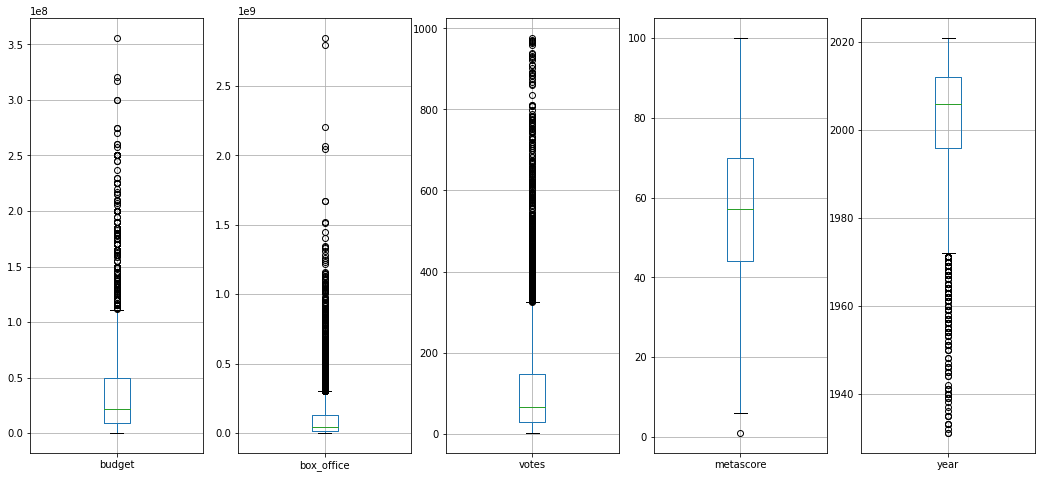

In [32]:
# create a box plot for each numerical column

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(151)
movies_df.boxplot(column=['budget'])

ax = fig.add_subplot(152)
movies_df.boxplot(column=['box_office'])

ax = fig.add_subplot(153)
movies_df.boxplot(column=['votes'])

ax = fig.add_subplot(154)
movies_df.boxplot(column=['metascore'])

ax = fig.add_subplot(155)
movies_df.boxplot(column=['year'])

plt.show()

It is clear from both the box plot and the data distribution diagrams that there exist many outliers within this dataset.

From these graphs we may discern that most movies have been produced in the 21st century and it is also quite clear that the metascore column is the only data which follows a normal distribution pattern.

All other features are inundated with outliers. The effect of outliers would be considerably worse on the budget and box_office boxplots had all currencies been allowed to remain.

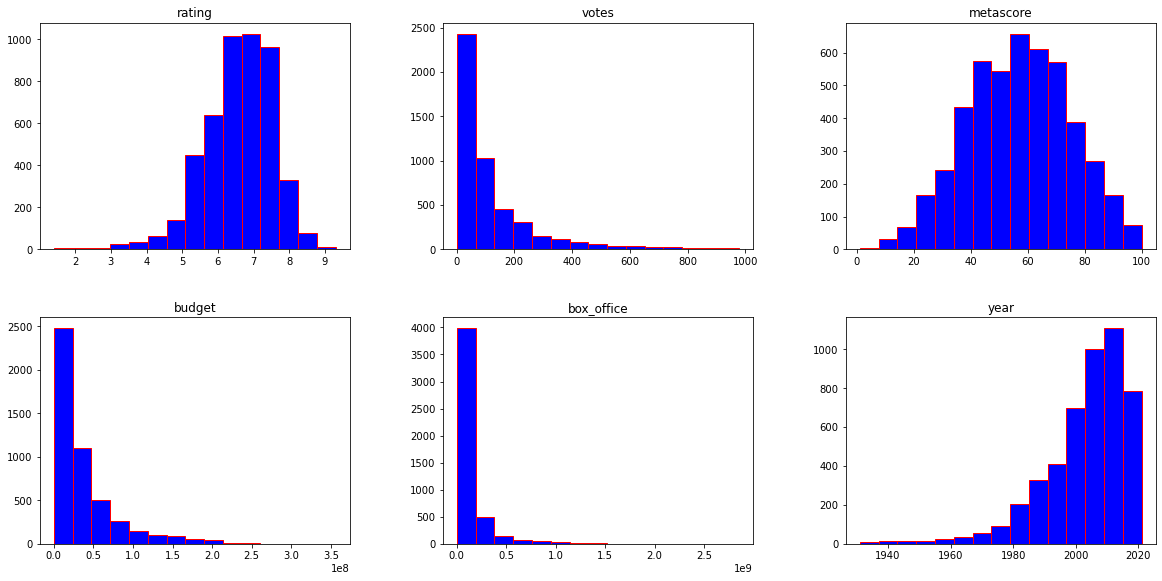

In [33]:
# using hist plots to get an understaning of the datasets distributions

movies_df[['rating', 'votes', 'metascore', 'budget', 'box_office', 'year']].hist(bins=15, figsize=(20, 15), color='blue', edgecolor='red', layout=(3, 3), grid=False)
plt.show()

In [34]:
# correlation between features of the data

corr = movies_df.corr()
corr.style.background_gradient(cmap='coolwarm')

One interesting feature to note is the budget. It would appear that a higher budget does indeed have a small effect on the votes cast for that movie. I would suspect a higher budgeted movie would also be advertised to a wider degree and this would in turn lead to more votes cast for that movie as opposed to lesser known films.

The budget also appears to have a profound effect on the gross and net revenue of the movie. I believe this could be the result of a number of factores. Firsly higher budgeted movies are typically aimed at a wider audience (family movies) so as to capture as much of the consumer base as possible. This may be obserbed in the graph below where the PG:12s have the highest proportion of the budget allocation. A second reason for the correlation between budget and box office revenue can be attributed to the scope and effects of the movie. A higher budget will naturally allow for more complex and stunning CGI but it also allows movies to be created based upon well established characters and heroes from books/TV shows and other media such as for example the Marvel characters.

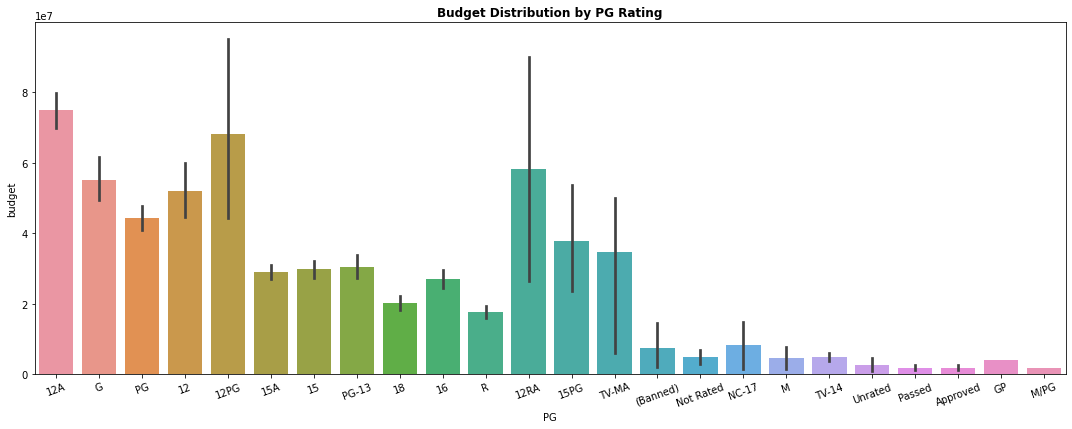

In [35]:
# sort movies by highest budget and visualise this against the PG rating

most_expensive = movies_df.sort_values(['budget'], ascending=False)

fig, axs = plt.subplots(figsize=(15,6))
g = sns.barplot(x=most_expensive['PG'], y=most_expensive['budget'])
plt.xticks(rotation=20)
plt.tight_layout()
g.set_title("Budget Distribution by PG Rating", weight = "bold")
plt.show()

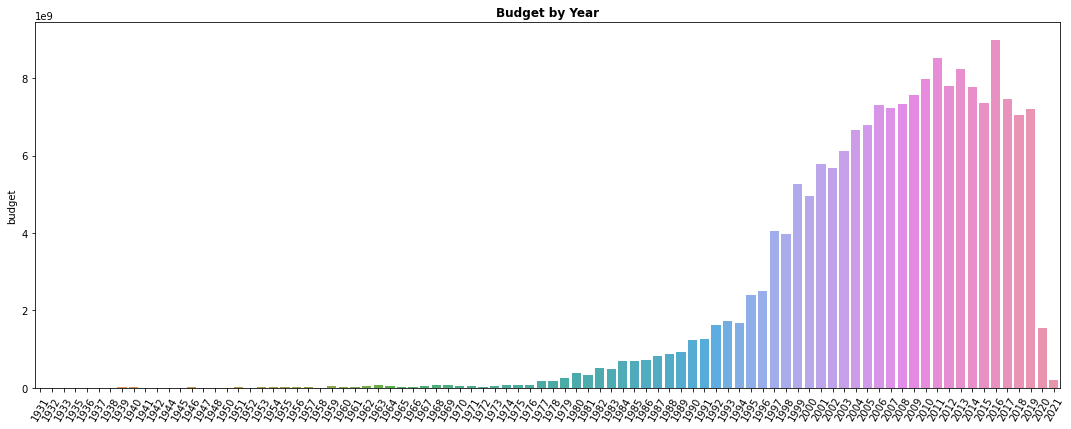

In [36]:
# sort year of release from smallest to largest and sum the budgets for the respective years

years_sort = movies_df.sort_values(['year'], ascending=True)

fig, axs = plt.subplots(figsize=(15,6))
g = sns.barplot(x=years_sort['year'].unique(), y=movies_df.groupby('year')['budget'].sum())
plt.xticks(rotation=60)
plt.tight_layout()
g.set_title("Budget by Year", weight = "bold")
plt.show()

Movies budget have risen substantially since the 1970s and have stagnated around the mean from 2006 onwards. There is also a very clear decrease in budgets and indeed movie production as a whole in 2020 with the emergence of the virus pandemic, which is to be expected. The year 2021 should be ignored as the year is not yet over and not enough data has been gathered.

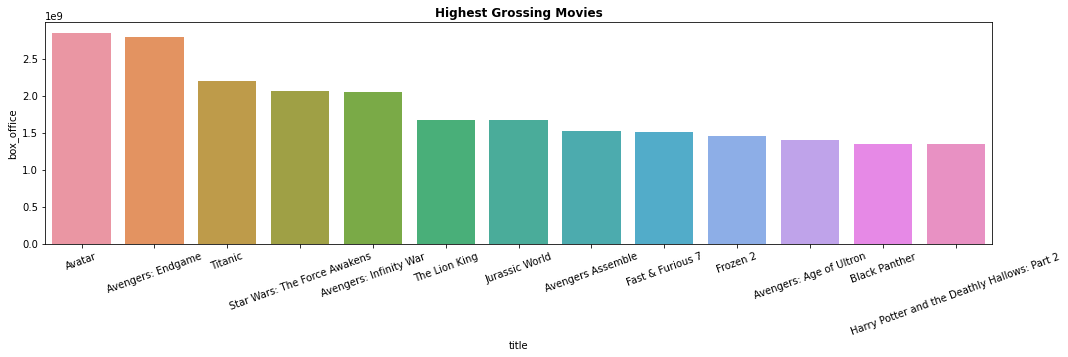

In [37]:
# examining the highest grossing movies to date

top_grossing = movies_df.sort_values(['box_office'], ascending=False)

fig, axs = plt.subplots(figsize=(15,5))
g = sns.barplot(x=top_grossing['title'][:13], y=top_grossing['box_office'][:13])
plt.xticks(rotation=20)
plt.tight_layout()
g.set_title("Highest Grossing Movies", weight = "bold")
plt.show()

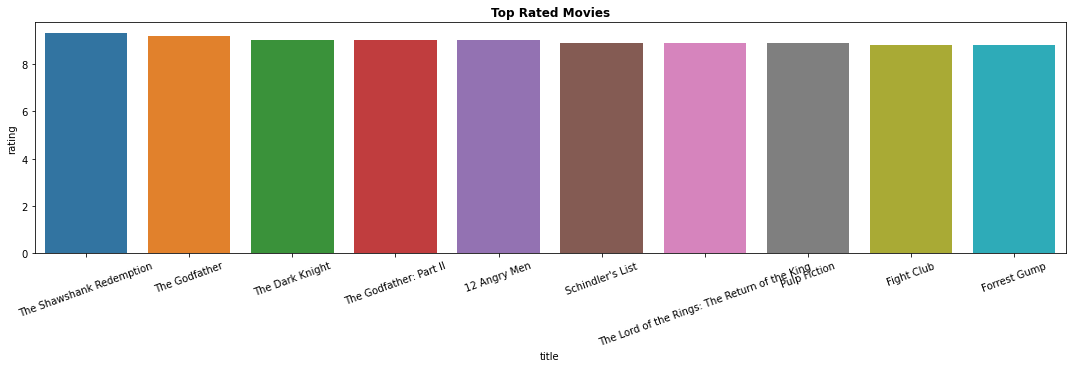

In [38]:
# examining the top rated movies to date

top_rated = movies_df.sort_values(['rating'], ascending=False)

fig, axs = plt.subplots(figsize=(15,5))
g = sns.barplot(x=top_rated['title'][:10], y=top_rated['rating'][:10])
plt.xticks(rotation=20)
plt.tight_layout()
g.set_title("Top Rated Movies", weight = "bold")
plt.show()

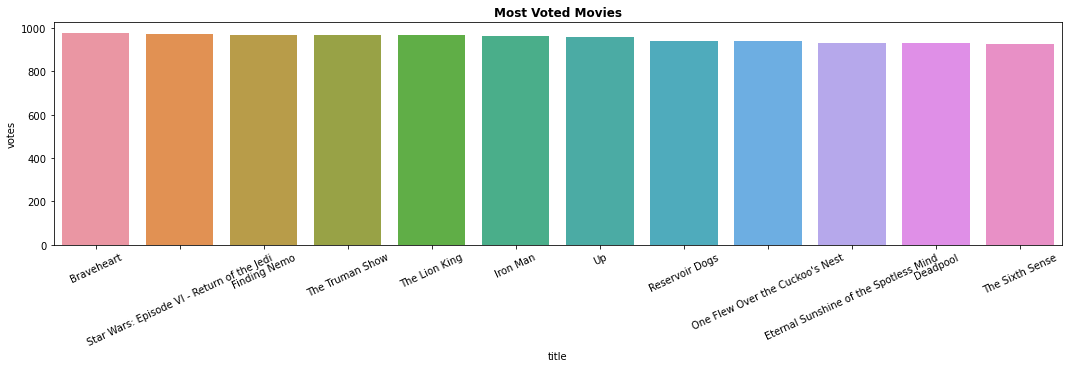

In [39]:
# examining the top voted movies to date

most_voted = movies_df.sort_values(['votes'], ascending=False)

fig, axs = plt.subplots(figsize=(15,5))
g = sns.barplot(x=most_voted['title'][:12], y=most_voted['votes'][:12])
plt.xticks(rotation=25)
plt.tight_layout()
g.set_title("Most Voted Movies", weight = "bold")
plt.show()

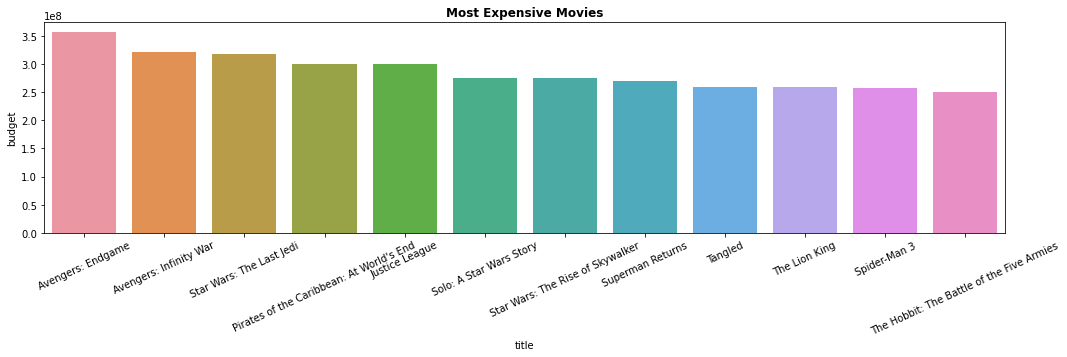

In [40]:
# examining the most expensive movies to date

fig, axs = plt.subplots(figsize=(15,5))
g = sns.barplot(x=most_expensive['title'][:12], y=most_expensive['budget'][:12])
plt.xticks(rotation=25)
plt.tight_layout()
g.set_title("Most Expensive Movies", weight = "bold")
plt.show()

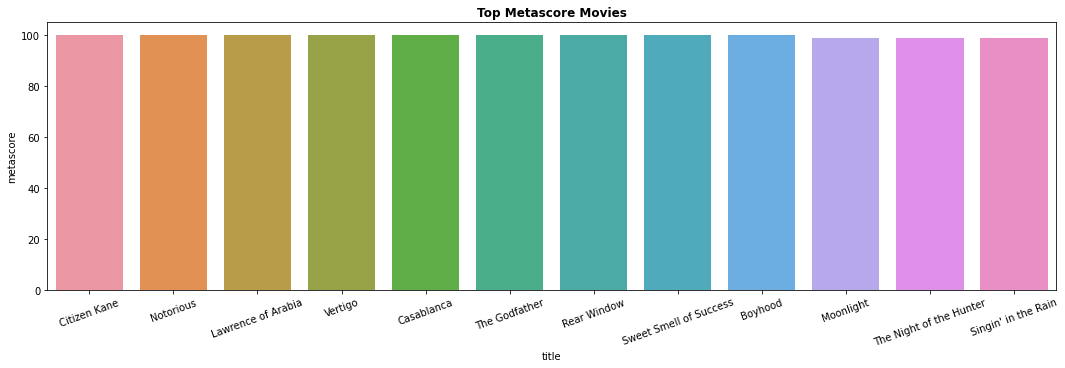

In [41]:
# examining the highest metascore movies to date

top_metascore = movies_df.sort_values(['metascore'], ascending=False)

fig, axs = plt.subplots(figsize=(15,5))
g = sns.barplot(x=top_metascore['title'][:12], y=top_metascore['metascore'][:12])
plt.xticks(rotation=20)
plt.tight_layout()
g.set_title("Top Metascore Movies", weight = "bold")
plt.show()

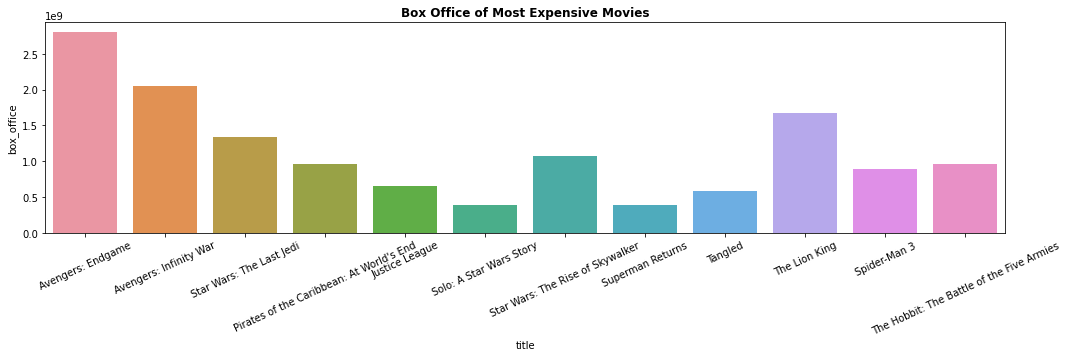

In [42]:
# examining the box office of the most expensive movies

fig, axs = plt.subplots(figsize=(15,5))
g = sns.barplot(x=most_expensive['title'][:12], y=most_expensive['box_office'][:12])
plt.xticks(rotation=25)
plt.tight_layout()
g.set_title("Box Office of Most Expensive Movies", weight = "bold")
plt.show()

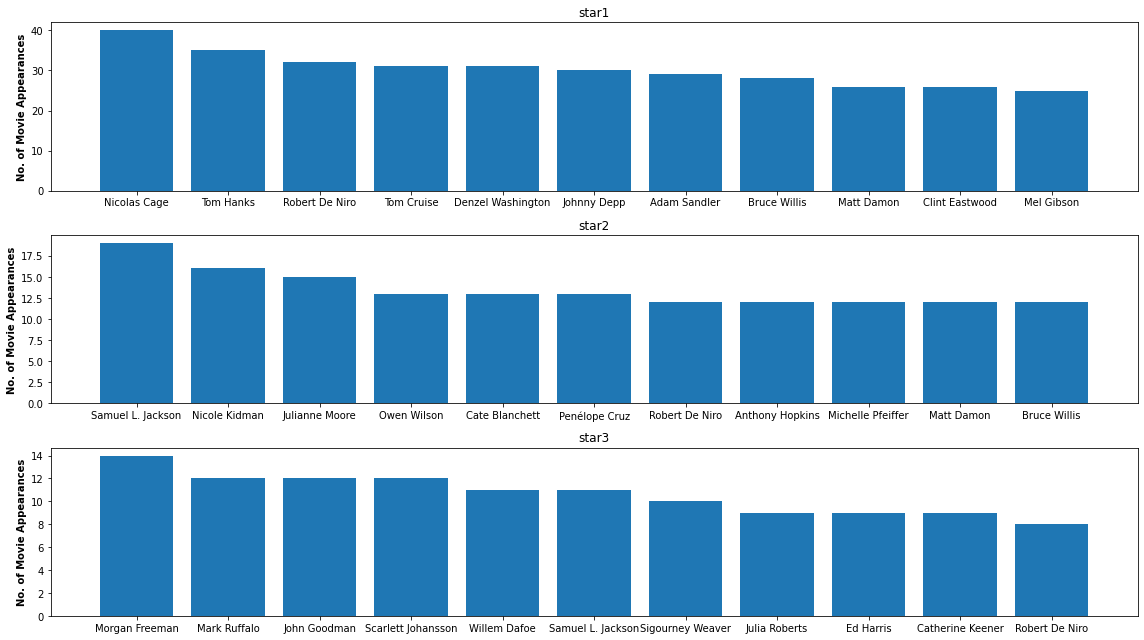

In [43]:
# actor appearances in movies

stars = ['star1','star2','star3']

fig, axs = plt.subplots(3, 1, figsize=(16,9))
c = 0
for i in stars:
    axs[c].bar(movies_df[i].value_counts()[:11].index, movies_df[i].value_counts()[:11])
    axs[c].set_title(i)
    axs[c].set_ylabel("No. of Movie Appearances", weight = "bold")
    c+=1
    plt.tight_layout()

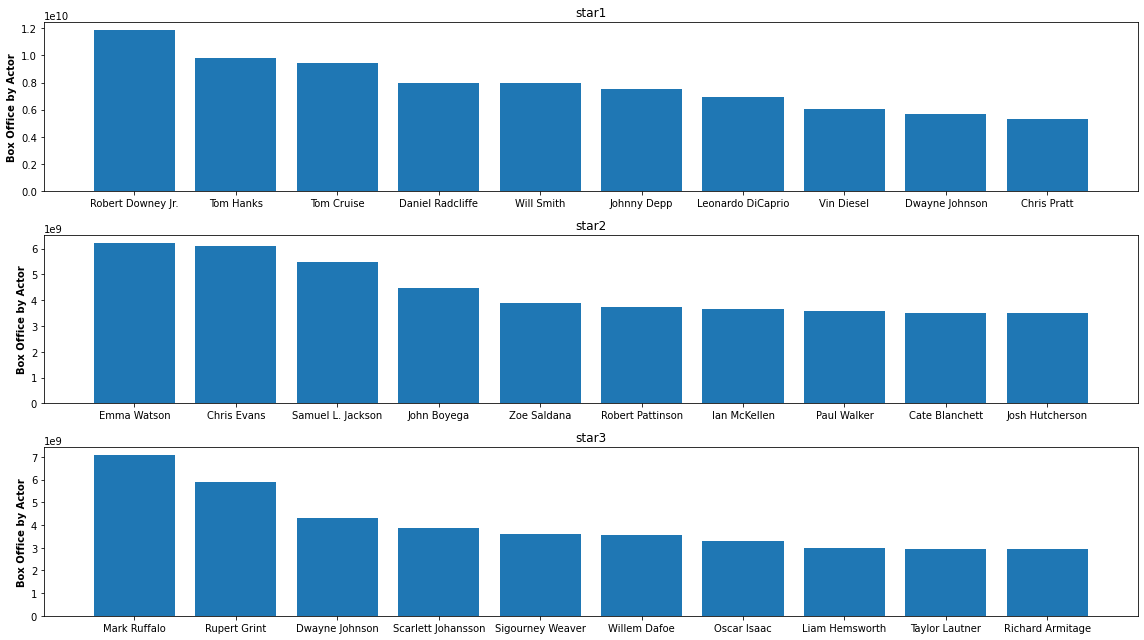

In [44]:
# box office by actor appearance

actors = ['star1','star2','star3']

fig, axs = plt.subplots(3,1,figsize=(16,9))

c = 0
for i in actors:
    actor_sum = movies_df.groupby([i]).sum().reset_index()
    actor_filter = actor_sum.sort_values(['box_office'], ascending=False)[:10]
    axs[c].bar(actor_filter[i],actor_filter['box_office'])
    axs[c].set_title(i)
    axs[c].set_ylabel("Box Office by Actor", weight = "bold")
    c+=1
    plt.tight_layout()

It is interesting to note that the most frequent actors are not the most succesful in terms of box office revenue. Robert Downey Jr. is a clear example of quality over quantity. That is not to say the most frequent actors are poor at their craft, this is purely a box office hit analysis.

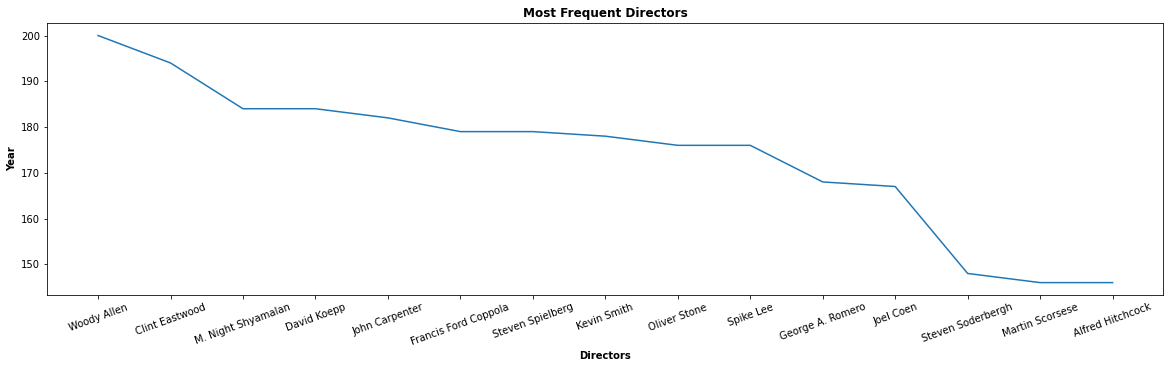

In [45]:
# examining the most frequent directors in the business

fig, axs=plt.subplots(figsize=(20,5))
g = sns.lineplot(x=movies_df['director'].value_counts()[:15].index,y=movies_df['year'].value_counts()[:15])
g.set_title("Most Frequent Directors", weight = "bold")
g.set_xlabel("Directors", weight = "bold")
g.set_ylabel("Year", weight = "bold")
plt.xticks(rotation=20)
plt.show()

It is interesting to note that some of the most prominent directors such as Woody Allen do not appear in the top 30 directors by box office revenue.

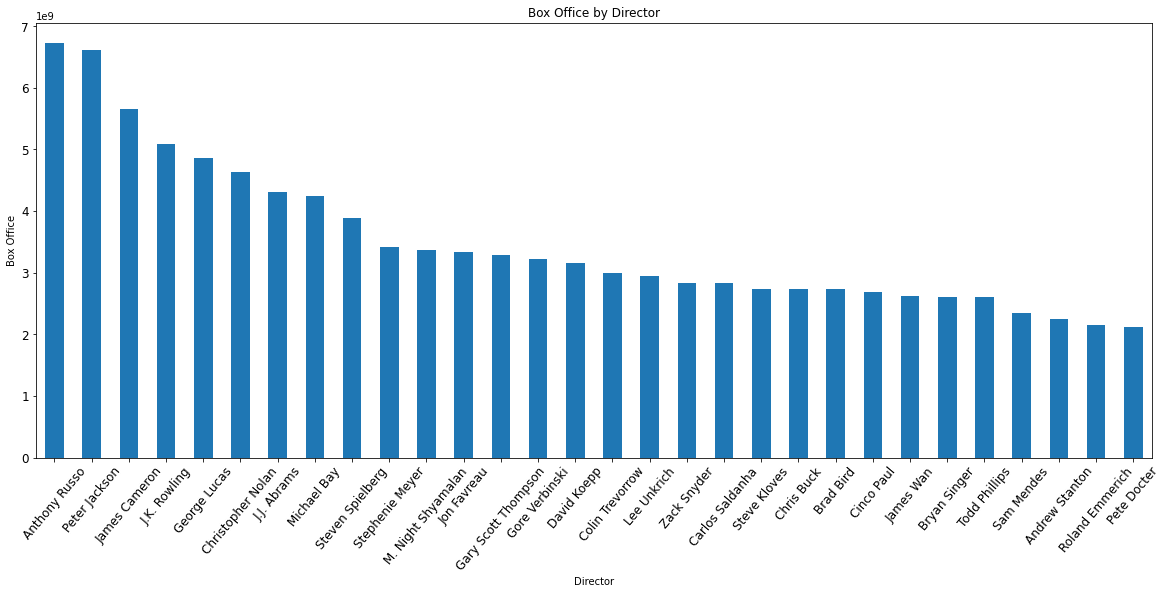

In [46]:
# visualising the gross revenue by director

gross_director = movies_df.groupby('director')['box_office'].sum()

gross_director.sort_values(ascending=False, inplace=True)

gross_director[:30].plot(kind='bar', figsize=(20, 8), title='Box Office by Director', xlabel='Director', ylabel='Box Office', rot=50, fontsize=12)
plt.show()

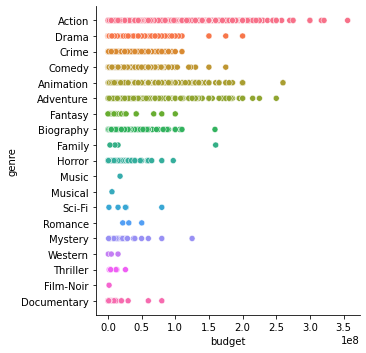

In [47]:
sns.relplot(data=movies_df, x='budget', y='genre', hue='genre', legend=False)
plt.show()

The graph above gives us an understanding of the most popular genres produced by film companies.


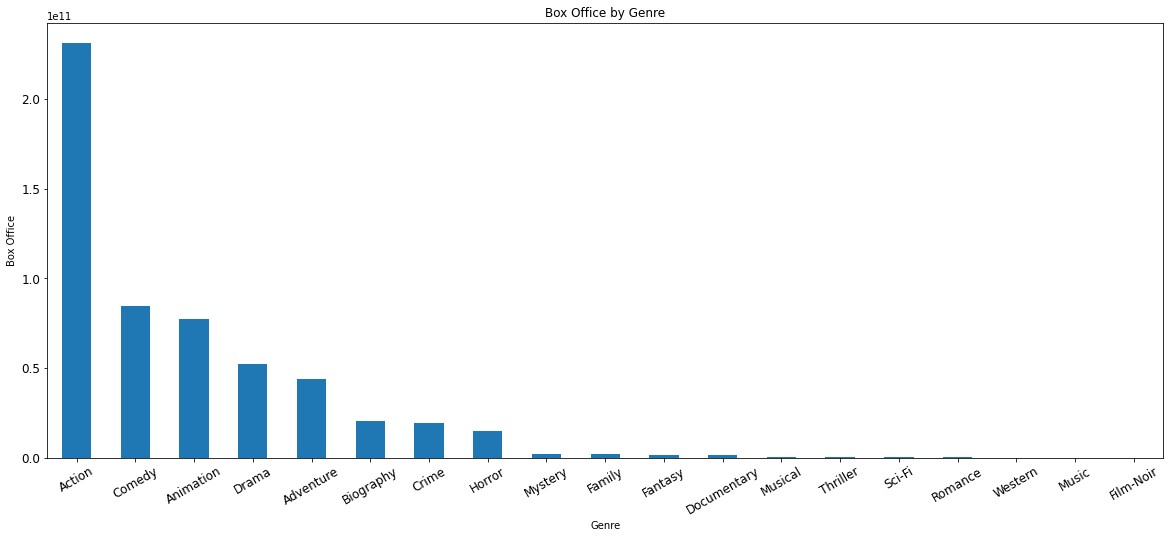

In [48]:
# visualising the gross revenue by genre

gross_genre = movies_df.groupby('genre')['box_office'].sum()

gross_genre.sort_values(ascending=False, inplace=True)

gross_genre[:30].plot(kind='bar', figsize=(20, 8), title='Box Office by Genre', xlabel='Genre', ylabel='Box Office', rot=30, fontsize=12)
plt.show()

Taking a closer look at box office by genres a very clear winner emerges. Action is by far the most successful genre and the reason for such a high budget allowance. Of course if the budgets had been redirected towards other genres we would see a substantial increase in their success however from this distribution we can get an understanding of what the average consumer enjoys at the cinema. 

From this observation an interesting question must be examined, what is the average age of cinema goers?

According to the www.screenaustralia.gov.au[1] website the most prominent age bracket for cinema atendees was 14-24 in Australia. Looking further at www.statista.com[2] a similar pattern emerges with 15-24 yea olds accounting for the roughly 28% of all movie goers in the UK. We can therefore summize this is would be the typical case across most of the 1st world.

From this it may be reasonable to conclude that the action genre is aimed at the younger audience whom enjoy and consume this type of media.

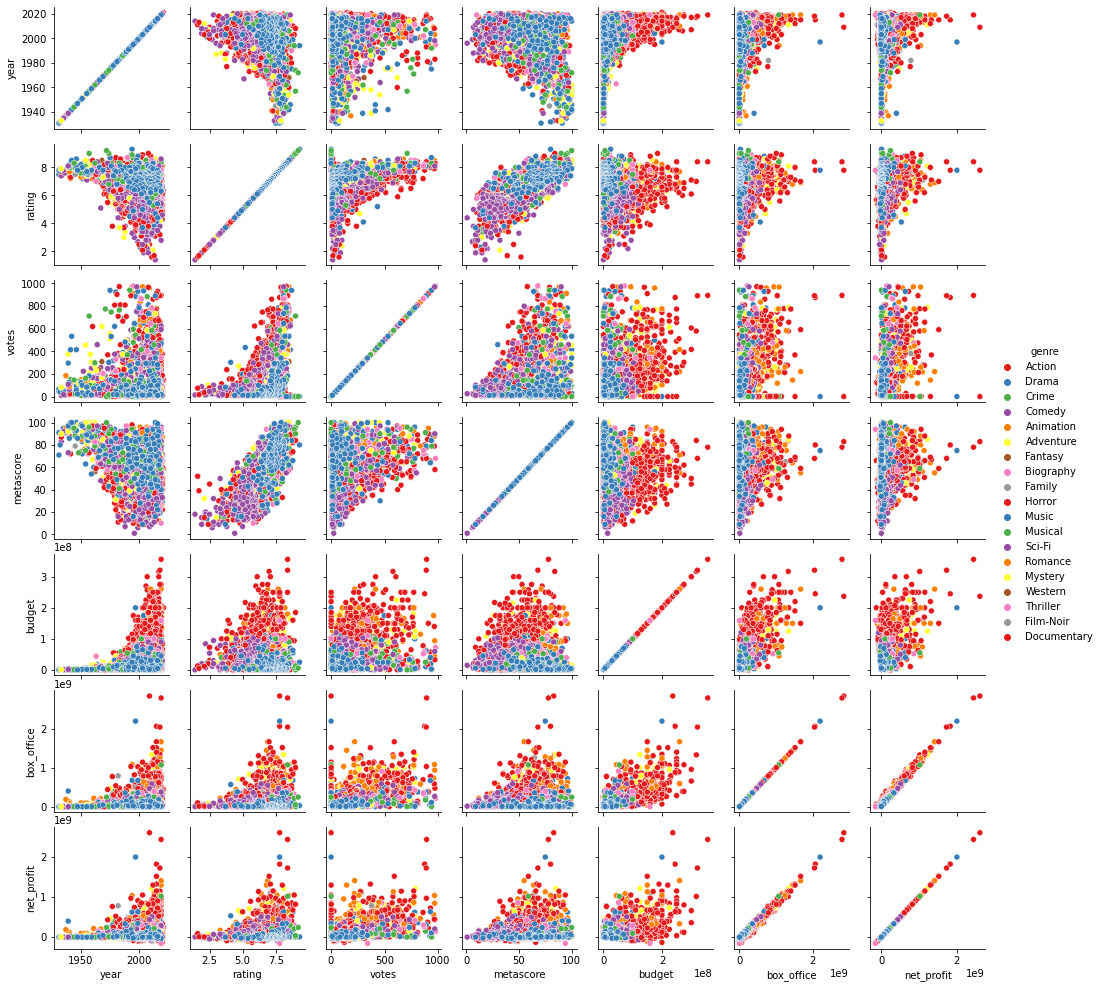

In [49]:
# exmaining all features of the dataset plotted against eachother

g = sns.PairGrid(movies_df, hue='genre', height=2, palette="Set1")
g.map(sns.scatterplot)
g.add_legend()
plt.show()

There are a few interesting points which may be deciphered from this pair grid.

It would appear that movies filmed in the early years are of much higher quality, in terms of storyline and so forth, as opposed to more recent films in the last decade. the metascore and rating where much higher in the early years of movie production. One could say that perhaps a greater effort was put into these early films due to the rarity and price of necessary equipment. However given the small number of movies produced in the early years compared to the modern era there may simply not be enough data for an accurate comparison. 

The year and budget features paint a similar picture the graphs previously observed, depicting a sharp increase in action and horror movies from the year 2000 onwards. We may also observe a correlation between budget and the rating as previously discussed. The budget and box office is surprisingly quite clumped and irregular suggesting that previously percieved correlation is due to strong positive outliers. This is indeed the observed case suggesting that a higher budget will not always lead to a succesful movie however I believe that a strong box office success, such as the outliers, would not be achievable without a strong budget.

Another interesting observation is that the votes tally per movie is quite irregular when compared to the budget. The budget does not seem to influence how many votes are cast per movie. Once again some very strong outliers may be the reason for previously observed correlation. 

It is clear from this graph that further investigation must be done to fully understand the effects of the features, which will be completed in part 2 of the project.

### Visualising the 'storyline'

Wordclouds are a good way of getting an insight into the textual data of a dataset. For this I have examined the key defining words for the entirety of the storyline column as well as breaking this down for each genre.

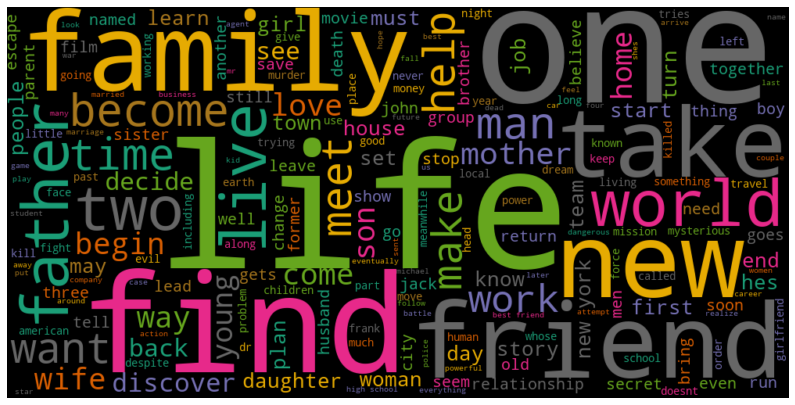

In [50]:
# wordcloud for the entirety of the dataset 'storyline'

text = ' '.join(movies_df['storyline'])

wc = WordCloud(background_color="black", colormap="Dark2", width=1000, height=500).generate(text)
plt.figure(figsize=(14,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Interestingly there appears to be a few crucial words which define the storyline as a whole. There is pattern to the storyline contained within these movies which give us an insight to the movies overall theme.

Life, one, find, family and new. These are very reptitive words which may be found in almost all genres as observed below. From this observation we may expect many movies to be similar textually and therefore be succesfully classified by a machine learning algorithm, however even though two movies are similar their success is still based upon a variety of other factores such as budget and director. I suspect that textual data alone will not be enough to predict the success of a movie.

In [51]:
# concatenate all storylines by genre for wordcloud

genre_text = movies_df.groupby('genre')['storyline'].apply(','.join).reset_index()

Find, world, friend, one; these are all too common words used to describe the storylines of the most successful and highly budgeted movies.

The action, animation and adventure genres are very similar to each other to the point where it is difficult to discern one from the other.

All other genre wordclouds are about as exepcted with words like 'love' found in drama and 'brother' observed in the family. Given this insight it would be almost impossible to discern between genres from their storyline alone.

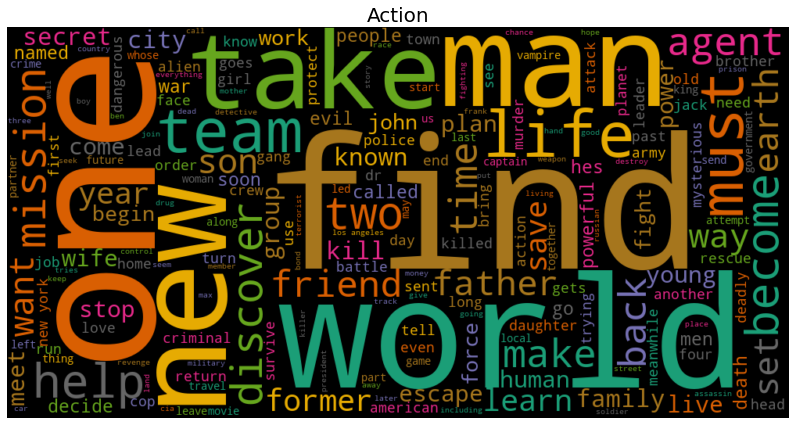

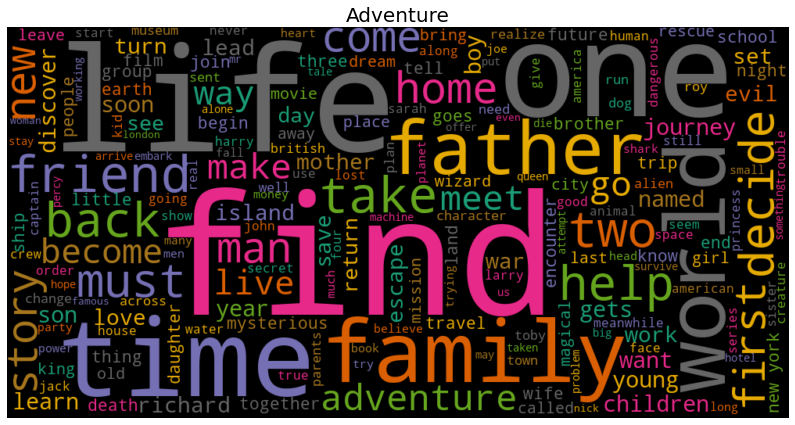

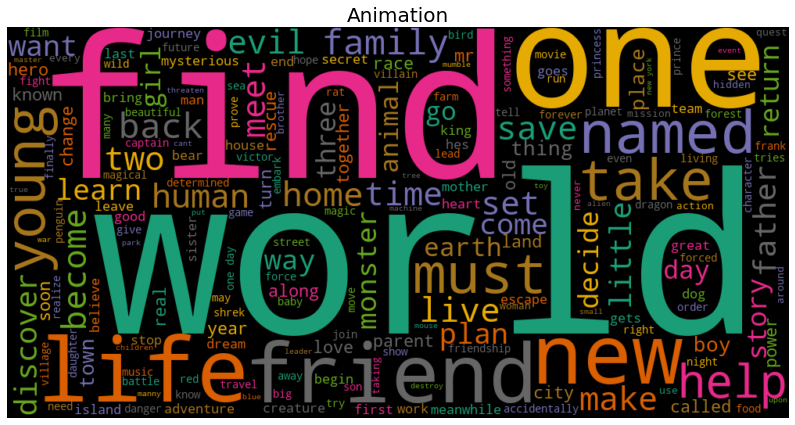

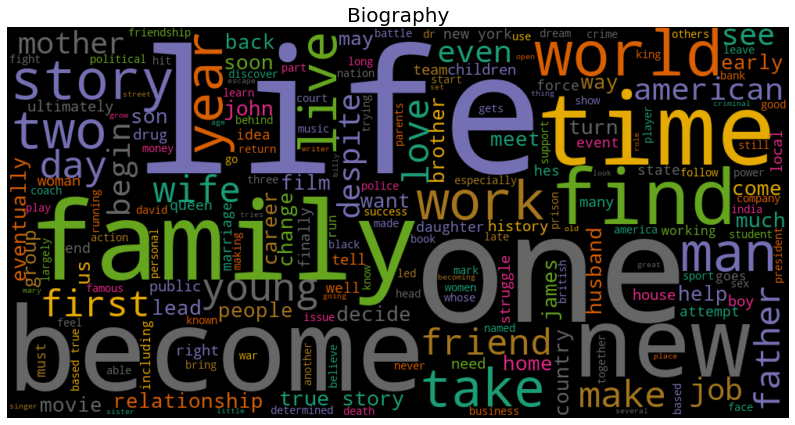

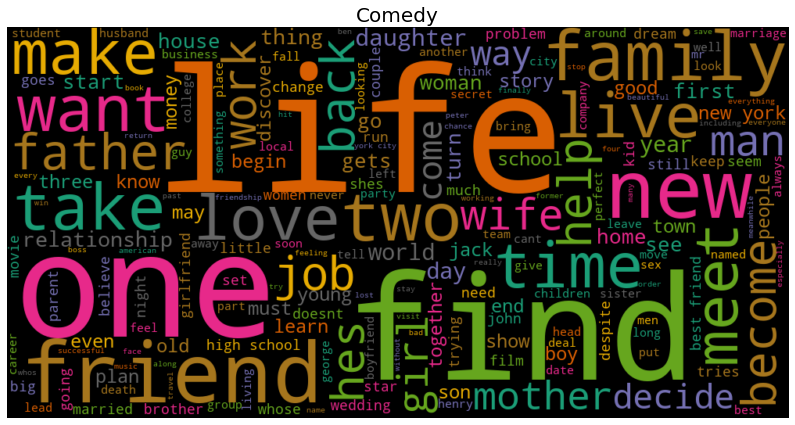

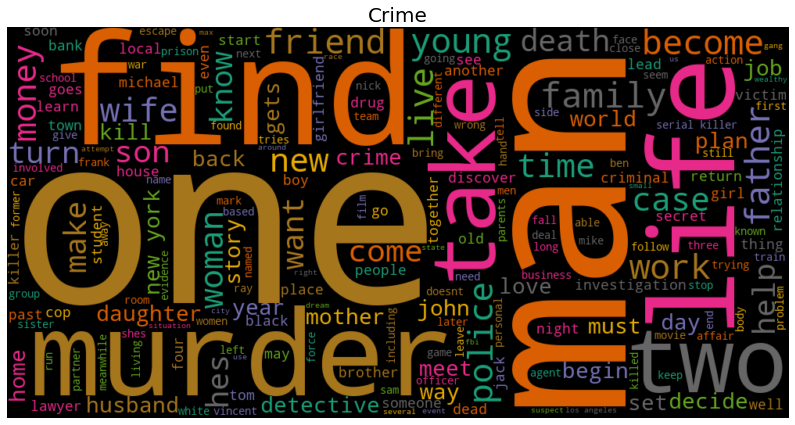

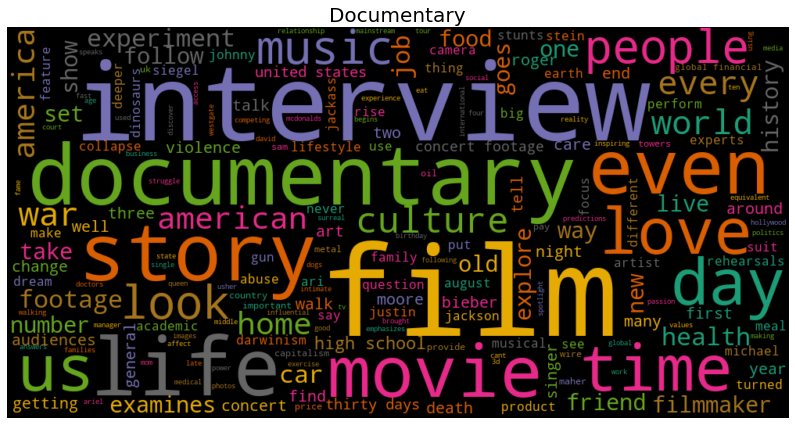

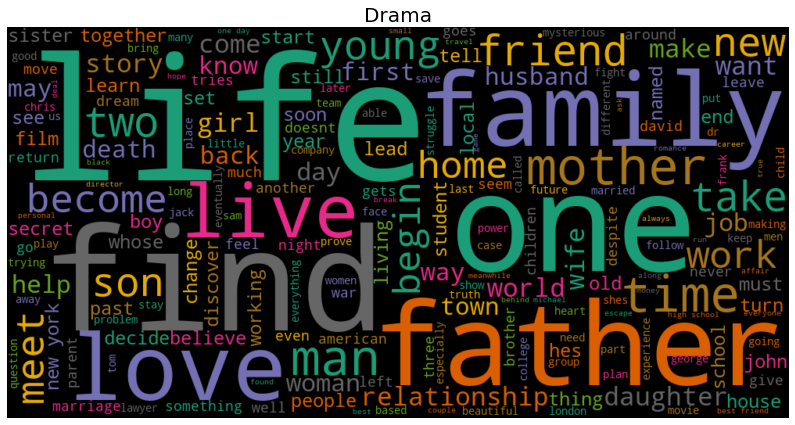

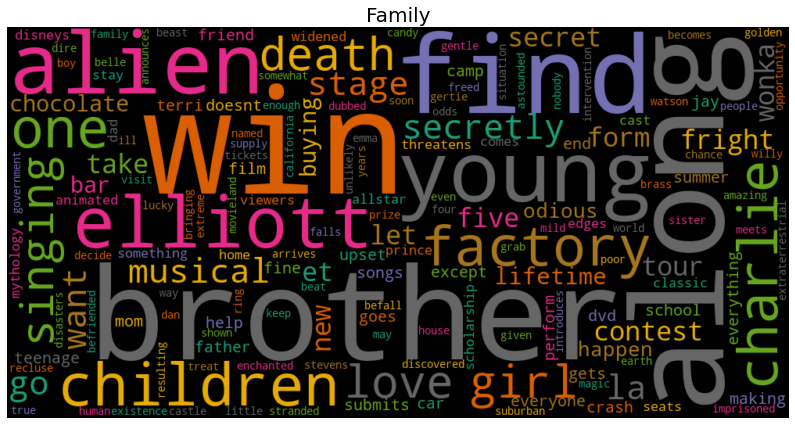

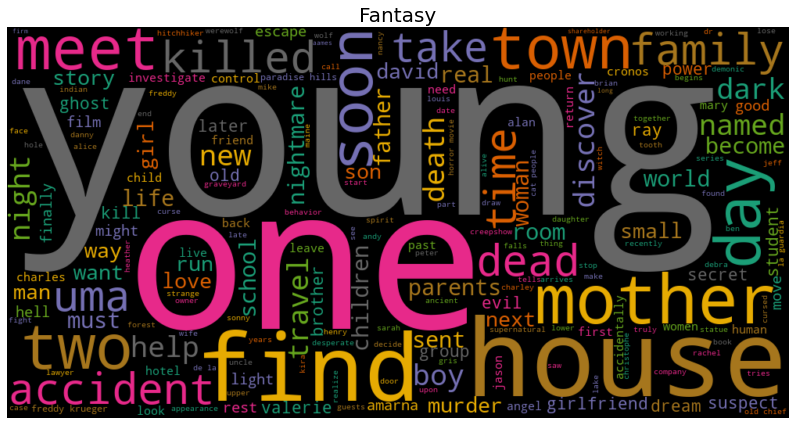

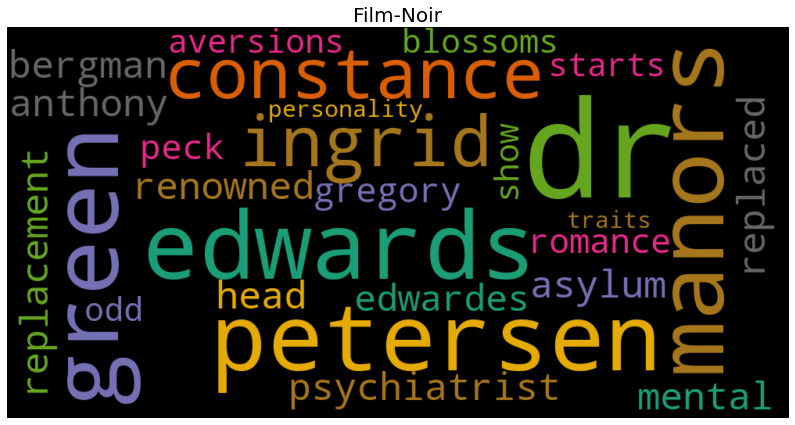

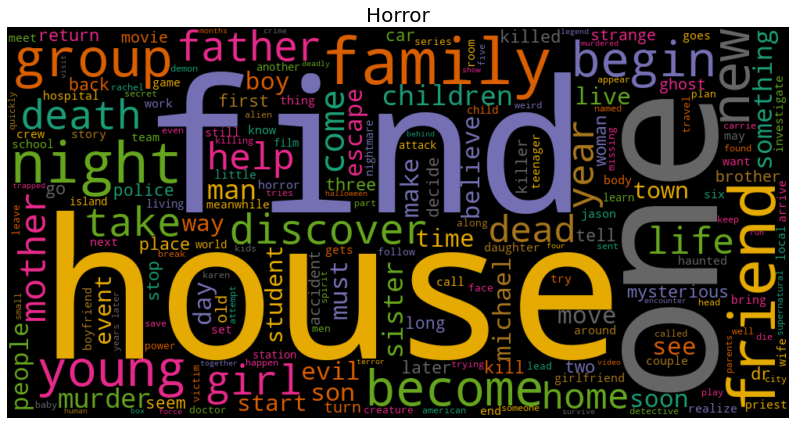

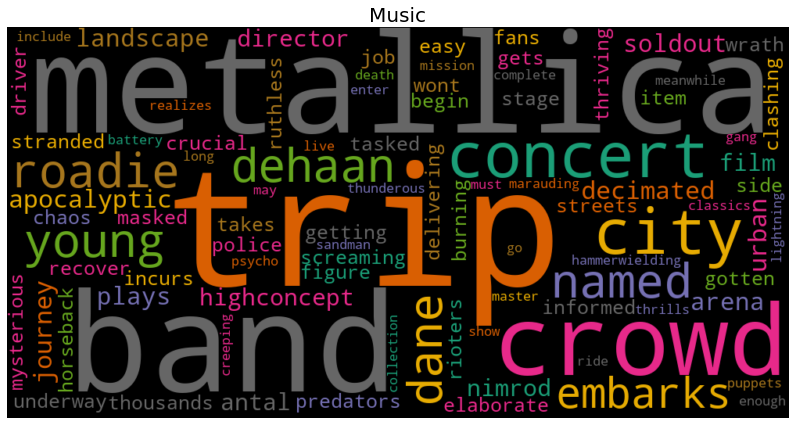

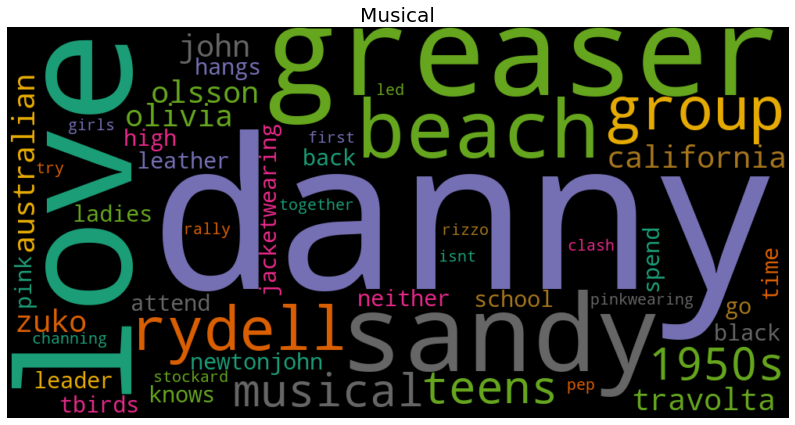

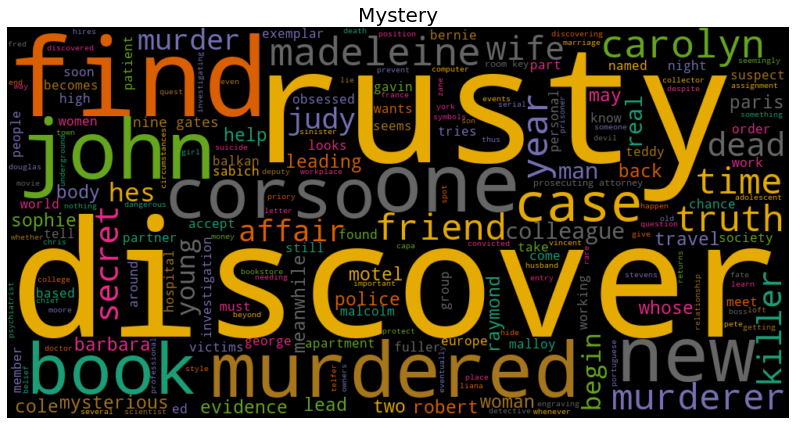

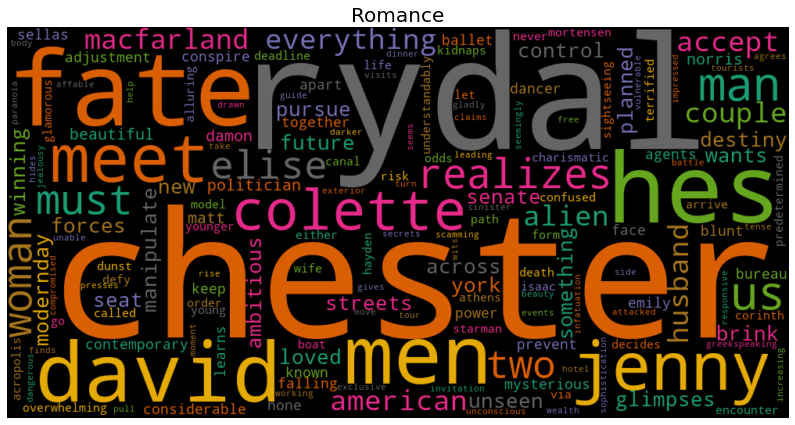

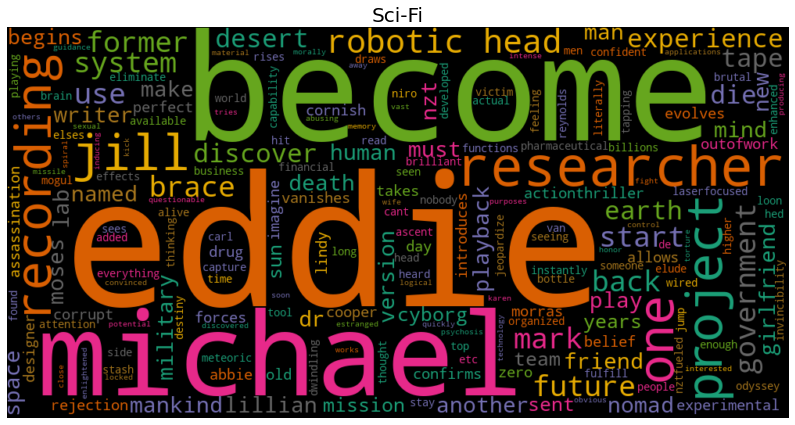

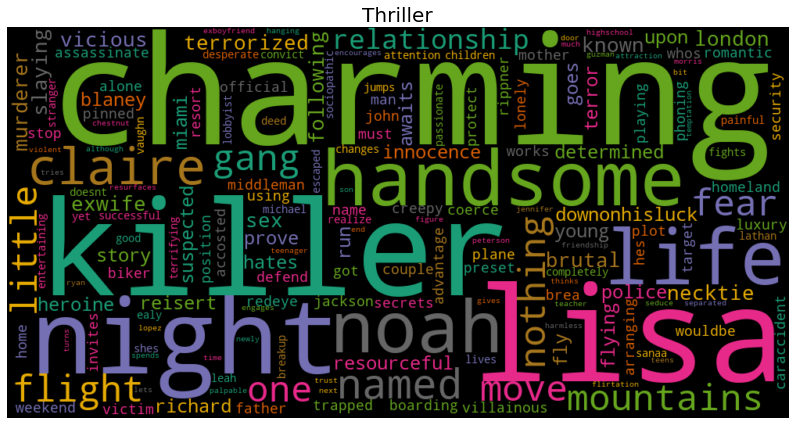

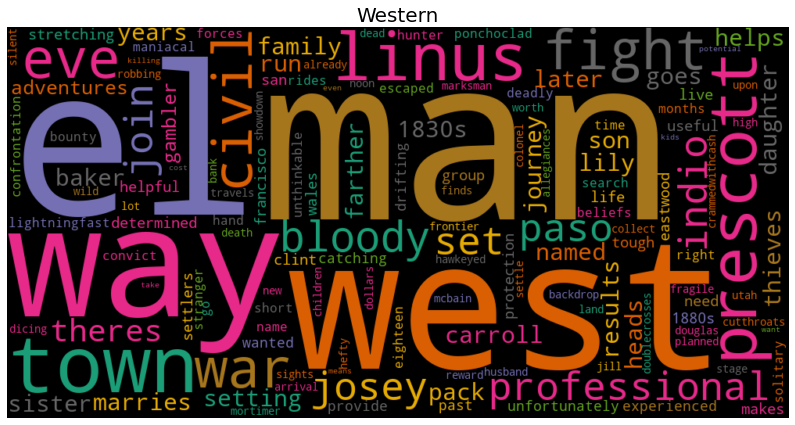

In [52]:
# create a wordcloud per each genre

for index, text in enumerate(genre_text['storyline']):
    wc = WordCloud(background_color="black", colormap="Dark2", width=1000, height=500).generate(text)
    plt.figure(figsize=(14,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(genre_text['genre'][index], fontsize=20)
    plt.axis("off")
    plt.show()

### Summary

Through an extensive but brief analysis of the dataset we have uncovered some interesting correlations between budget, votes and box office revenues. However the top level data appears to be contradicting itself when viewed through a pairplot. As a result further investigation must be made to uncover if any correlation does indeed exist between these features. 

With regards to future aspirations for the analysis of this dataset, I would like to apply machine learning algorithms to the storyline column and attempt to predict the success of a movie from its description. This would of course be accompanied by further investigation into each aspect of the movie. I suspect that that this will not be enough to accurately preduict a movies success and further features will be incorporated as a result. For example one hot encoding may be used on the directors and actors to allow for feature inputs.

I believe that it should also be possible to construct a movie recommendation system from this data set which would recommend a movie based upon the genre requested. The one issue with this, as stated in the next section, is that this dataset is skewed towards the most popular genres and as such the less popular ones do not have enough volume of data behind it.

### Potential Issue with the Dataset

One issue with this dataset is the total number of movies scraped using the scrapy spider. Originally there were 8192 movies scraped, however after the data pre-processing pipeline only 4802 entries remained in the dataframe. While this is still a good result it does mean that a lot of potentially crucial data was lost and therefore the data remains incomplete. I believe the data is somewhat incomplete due to the low number of movies which were retained in the genres observed below.

Many obervation were made regarding the top movies and its most succesful genres and the lack of data in the lesser known categories distorting the analysis. The reason for this lies in the way movies are categorised. Typically a movie will have more than one genre associated with it and as such we must pick and choose which values we use and which we discard. With regards to the imdb website and the scrapy spider, any duplicate movie urls were discarded, which means if a movie is listed multiple times under different genres, only the first will be scraped and all others discarded. 

One way to rectify this issue would be to scrape the entirety of the imdb website, which would increase the dataset tremendously however this would take a very long time to accomplish and would be extremely taxing on the websites servers. I have also pondered the question of joining multiple datasets together with my own, however the prominent issue in this case is that existing datasets do not contain all of the information I wish to analyse and as such would leave the dataset incomplete. There is no easy answer to this issue however I do believe that there is enough quality data in this dataset to continue with my analysis in part two.

In [53]:
movies_df.groupby('genre')['title'].count()

genre
Action         1195
Adventure       293
Animation       267
Biography       329
Comedy         1213
Crime           336
Documentary      38
Drama           805
Family            4
Fantasy          36
Film-Noir         1
Horror          245
Music             1
Musical           1
Mystery          20
Romance           3
Sci-Fi            5
Thriller          6
Western           4
Name: title, dtype: int64

### Bibliography

[1] Screen Australia. 2021. By age - Attendance patterns - Audiences - Cinema - Fact Finders - Screen Australia. [online] Available at: <https://www.screenaustralia.gov.au/fact-finders/cinema/audiences/attendance-patterns/by-age> [Accessed 4 July 2021].

[2] Statista. 2021. Cinema audience demopgraphics | Statista. [online] Available at: <https://www.statista.com/statistics/296240/age-and-gender-of-the-cinema-audience-uk/> [Accessed 4 July 2021].